<a href="https://colab.research.google.com/github/FDawnXingLin/colab-notebook/blob/master/OpenCV_CascadeDetector_Cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1-训练前的准备

### 1.1-目录的组织
在本例中，所有的样本处理和训练都在Colab笔记本上进行，我在GoogleDrive上创建目录，储存样本。然后将其连接到Colab。


文件目录的组织: 
*   ./Cup/Image/GrayscaleAndResize 用于储存原始样本图片
*   ./Cup/Image/Origin/Positive 用于储存原始正样本图片
*   ./Cup/Image/Origin/Negative 用于储存原始负样本图片
*   ./Cup/Image/GrayscaleAndResize 用于储存灰度化和调整大小后的样本图片
*   ./Cup/Image/GrayscaleAndResize/Positive 用于储存灰度化和调整大小后的正样本图片
*   ./Cup/Image/GrayscaleAndResize/Negative 用于储存灰度化和调整大小后的负样本图片
*   ./Cup/Result 用于储存生成的中间文件及训练结果
*   ./Cup/Test 用于储存用于测试分类器所用的样本



按照上面的组织结构在GoogleDrive中创建目录并上传原始数据，执行以下命令来连接到GoogleDrive(命令来自于:Jeff Heaton):

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


你可以点击左边菜单中的文件选项，然后在打开的栏目中查看你挂载的文件目录。我的项目目录挂载在了：
/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup

### 1.2-样本的准备
想要使用OpenCV训练级联分类器，你需要同时准备正样本和负样本。
#### 1.2.1-正样本
正样本即（仅）包含目标物体的图片。
根据目标物体复杂度的不同，所需要的正样本数也不相同。比如说如果只想要检测单一的标志，则只需要准备这个标志。而像人脸这样复杂多变的对象，就需要大量的正样本。
我使用了二十张带把杯子的照片作为样本。
#### 1.2.2-负样本
负样本则是要求不包含目标物体。
想要让训练出的级联分类器准确性更高，就需要选择更高质量（更有迷惑性的）的负样本。如果选取的负样本不够有区分性，则有可能导致训练出的级联分类器较浅，效果更差。（个人理解，如果我用杯子的样本进行训练，而没有在负样本中添加类似但不一样的样本的话，则这个分类器的误识别概率将会很大。）

### 1.3-样本的处理

#### 1.3.1-正样本的处理
正样本的处理主要包括以下几个步骤：
*   剪裁
*   灰度化
*   大小统一化
*   生成标记文本
*   生成.vec

**剪裁：**
样本中的多余部分不仅会降低训练精度，还会使其效率降低。所以我们需要对样本进行剪裁，仅仅保留其主体。我将所以正样本都剪裁成了正方形样本（拍摄时已经选取了单一背景），保存在了./Cup/Image/Origin/Positive。  

**灰度化：**
将剪裁好的样本转化为灰度图片。（这一步是必要的，否则OpenCV会报错。）你可以使用下面的程序来同时进行灰度化和大小统一化。  

**大小统一化：**
OpenCV对正样本的大小并没有硬性规定，但是要求所用样本大小一致（且大小合适，一般来说，100x100以下是一个合适的值，较大的值可能会使训练变得很慢）。这里我选择80x80大小。你可以使用下面的程序来同时进行灰度化和大小统一化。  
**生成标记文本：**
在完成上面的步骤之后，你需要在处理好的图片的目录中创建一个标记文本，使其包含图片的信息。下面这个程序将会自动化这个过程。  
标记文本的格式为：样本路径 检测目标数 起始检测坐标X 起始检测坐标Y 图片宽W 图片高H  
如果你的图片中含有多个目标，这个自动化程序可能不适用。

In [ ]:
import cv2
import os
o_pos="/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/Origin/Positive" #你的原始正样本文件夹路径
g_pos="/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive" #你的灰度化及大小统一化后的正样本文件夹路径
h=80 #高
w=80 #宽
pos_file=open(g_pos+"/pos.txt","w")
for files in os.listdir(o_pos):
    img = cv2.imread(o_pos+"/"+files,0)
    cv2.imwrite(g_pos+"/"+files,cv2.resize(img,(h,w)))
    pos_file.write(files+" 1"+" 0"+" 0"+" "+str(w)+" "+str(h)+"\n")
    # 在生成的pos.txt中，我仅仅将样本路径指定为文件名。因为在下文生成.vec的命令中，生成程序将会把pos.txt所在的路径和pos.txt中的所在路径相拼接而产生一个错误的路径。如果你在其他平台中使用这一套命令却发生了错误，那么你需要观察报错信息并修改代码来产生正确的拼接字符串
pos_file.close()
print("Done")

Done


**生成.vec：**
然而，实际上，我们用于级联分类器训练所用到的是.vec文件。在Linux系统中，如果你安装了OpenCV，那么用于生成.vec文件的opencv_createsamples将会出现在/usr/bin下。你可以使用以下的命令来生成.vec文件。

```
# 如果你不是在colab中执行此命令，那么请去除命令开头的"!"，在接下来的命令中也是如此。
# 因为在Colab中cd进入目录的命令所产生的效果并不会持续生效，所以我们需要在命令中使用绝对路径
opencv_createsamples -vec pos.vec -info pos.txt -num 100 -w 80 -h 80 
```
使用前你可以根据实际情况修改想生成pos.vec文件的路径（-vec），样本信息（-info）pos.txt的位置，以及样本所使用的统一的宽（-w）和高（-h）和生成的正样本数量（-num）。


In [ ]:
!sudo opencv_createsamples -vec /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive/pos.vec -info /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive/pos.txt -num 20 -w 80 -h 80 

Info file name: /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive/pos.txt
Img file name: (NULL)
Vec file name: /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive/pos.vec
BG  file name: (NULL)
Num: 20
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 80
Height: 80
Max Scale: -1
Create training samples from images collection...
Done. Created 20 samples


#### 1.3.2-负样本的处理
相对于正样本的处理来说，负样本的处理极其简单。只要将负样本灰度化，并用其路径生成一个标记文件即可。使用下面的程序可以简单的做到这点。

In [ ]:
import cv2
import os
o_neg="/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/Origin/Negative" #你的原始正样本文件夹路径
g_neg="/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Negative" #你的灰度化及大小统一化后的正样本文件夹路径
neg_file=open(g_neg+"/neg.txt","w")
for files in os.listdir(o_neg):
    img = cv2.imread(o_neg+"/"+files,0)
    cv2.imwrite(g_neg+"/"+files,img)
    neg_file.write(g_neg+"/"+files+"\n")
neg_file.close()
print("Done")

Done


在neg.txt生成后，我把pos.vec与neg.txt放在了同一个目录下，这样可以简化训练器生成的命令。（你也可以忽略这步，然后使用绝对路径）

In [ ]:
!mv /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Positive/pos.vec /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result
!mv /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Image/GrayscaleAndResize/Negative/neg.txt /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result

## 2-分类器生成
我们使用opencv_traincascade来对分类器进行训练：


```
opencv_traincascade -data /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/cup -vec /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/pos.vec -bg /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/neg.txt -numPos 4 -numNeg 12 -numStages 4 -w 80 -h 80
```
值得注意的是，"-data"参数指定了一个用于存放训练结果的目录而不是文件名，在colab中，你应该使用绝对路径。其他参数如下：
*   -numPos 每级分类器训练所使用的正样本数目，应少于正样本总数。
*   -numNeg 每级分类器训练所使用的负样本数目，可大于负样本总数，但是要由可用内存决定。
*   -numStages 训练分类器级数。




In [25]:
!opencv_traincascade -data /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/cup -vec /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/pos.vec -bg /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/neg.txt -numPos 15 -numNeg 100 -numStages 8 -w 80 -h 80

tcmalloc: large alloc 1879048192 bytes == 0x55bd4b6e4000 @  0x7fe382186887 0x55bcd954e863 0x55bcd954f383 0x55bcd954b481 0x55bcd954d1e1 0x55bcd9548ae2 0x55bcd9535fff 0x7fe380641c87 0x55bcd9536c1a
tcmalloc: large alloc 3758096384 bytes == 0x55bdbb6e4000 @  0x7fe382186887 0x55bcd954e863 0x55bcd954f215 0x55bcd954b481 0x55bcd954d1e1 0x55bcd9548ae2 0x55bcd9535fff 0x7fe380641c87 0x55bcd9536c1a
PARAMETERS:
cascadeDirName: /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/cup
vecFileName: /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/pos.vec
bgFileName: /content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/neg.txt
numPos: 15
numNeg: 100
numStages: 8
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 80
sampleHeight: 80
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC
Number of unique features give

## 3-分类器检测
在上文中，我们已经训练好了一个级联分类器。我们可以使用以下的代码导入一张图片并用生成的分类器进行识别，返回一个标记好的结果。  

**测试用样本：**Photo by NordWood Themes on Unsplash

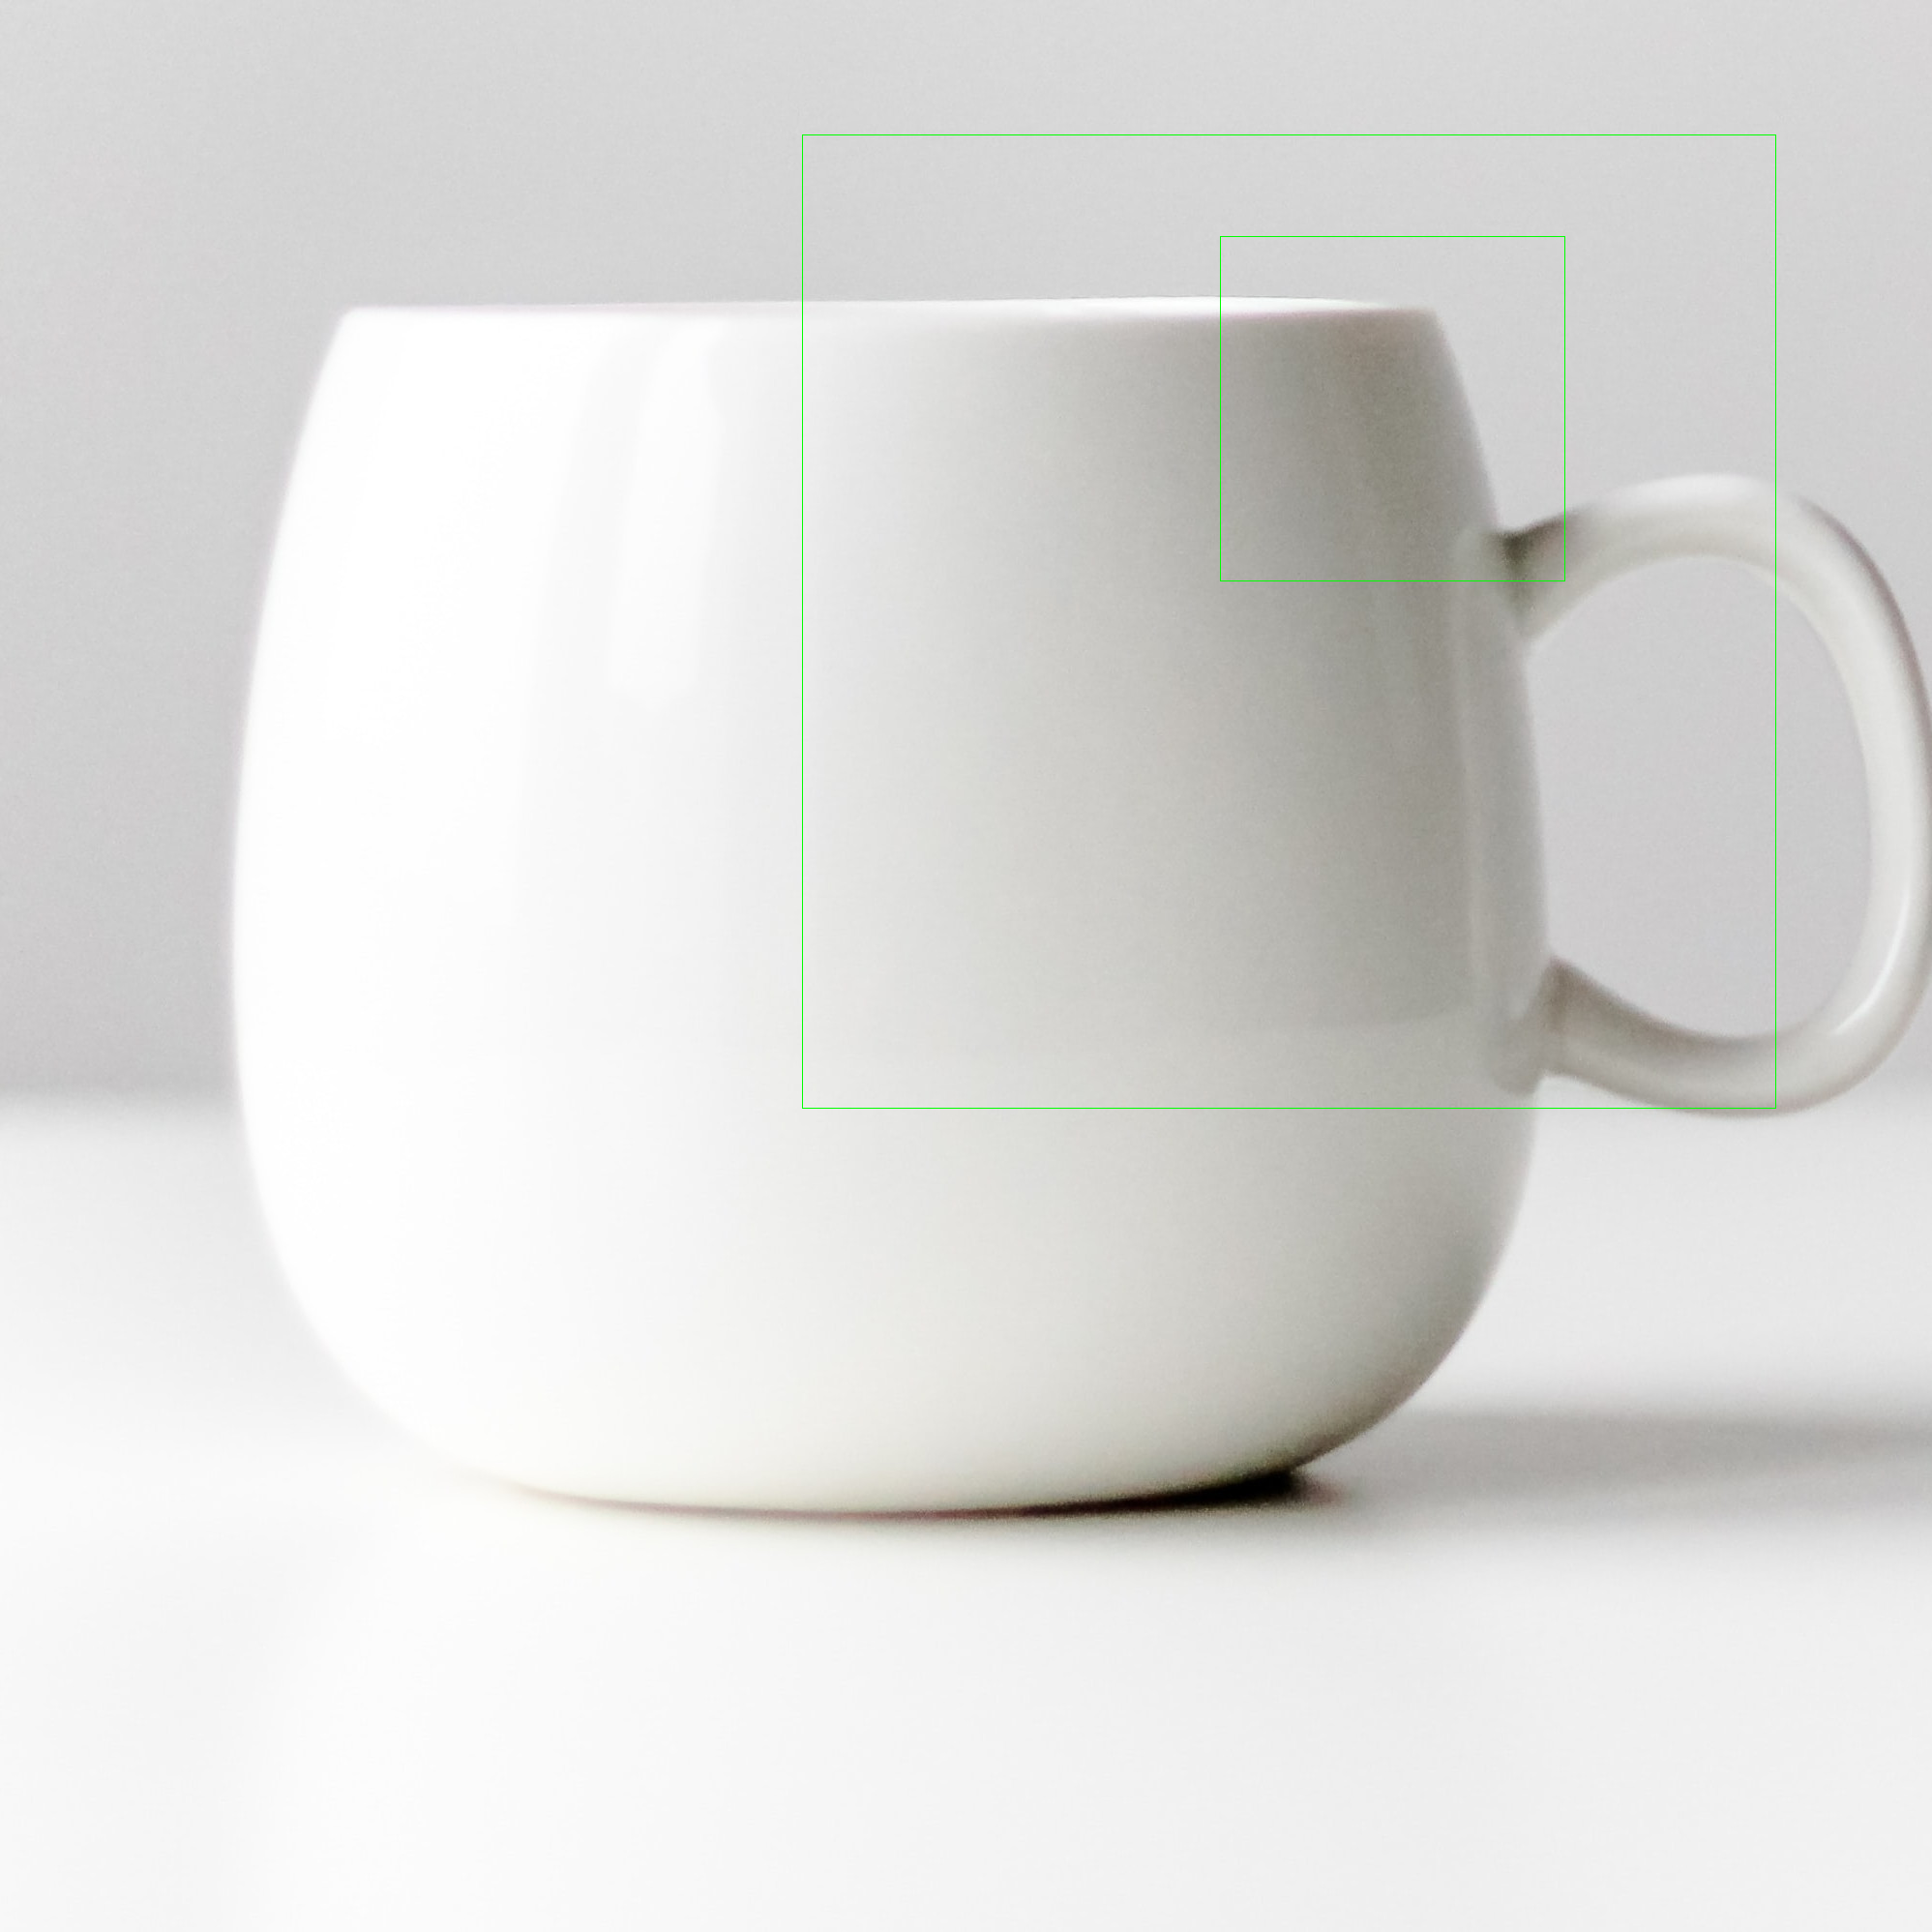

In [2]:
import cv2
from google.colab.patches import cv2_imshow

cascade = cv2.CascadeClassifier('/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Result/cup/cascade.xml')
img = cv2.imread('/content/drive/MyDrive/ComputerVision/CascadeDetector/Cup/Test/1.jpg')
img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
detector = cascade.detectMultiScale(img_gray)

for (x,y,w,h) in detector:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
cv2_imshow(img)

可以看到，这个分类器可以简单的识别样本，但是精度不忍直视。（它好像抓到了杯把的特征😂）在下一篇文章中，我将更深入的找出训练一个高可用性的级联分类器的方法。